# NOTE: This code was not run for the Anaheim, Sydney, or Winnipeg networks

# Imports

In [1]:
import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt
import collections
import time
import signal
from typing import List, Tuple

# Degree Network

Create a network with a desired degree - code start taken from lecture and ChatGPT was used to help create a working version. Link to chat: https://chat.openai.com/share/6d50a46c-cb21-4e5d-9173-7e5b37c031d3


In [3]:


def configuration_A(S):
    """Configuration model with degree sequence S"""
    stubs = []
    for i in range(len(S)):
        for j in range(S[i]):
            stubs.append(i)
    n = nx.Graph()
    n.add_nodes_from(range(len(S)))  # Ensure the graph has len(S) nodes
    while len(stubs) > 1:  # Need at least 2 stubs to form an edge
        v, w = random.sample(stubs, 2)
        if v != w:  # Avoid self-loops
            n.add_edge(v, w)
            # Remove v, w from stubs
            stubs.remove(v)
            stubs.remove(w)
    return n

def configuration_B(n, P):
    """Configuration model with degree distribution P"""
    S = [1]
    while not nx.is_valid_degree_sequence_erdos_gallai(S):
        S = random.choices(population=range(len(P)), weights=P, k=n)
    return configuration_A(S)
def plot_graph(G):
    """Plot the given graph G using matplotlib"""
    plt.figure(figsize=(8, 8))
    nx.draw(G, with_labels=True, node_color='skyblue', node_size=700, edge_color='k')
    plt.show()


def plot_degree_distribution(G, P):
    """Plot the degree distribution of graph G and compare it with distribution P"""
    degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
    degreeCount = collections.Counter(degree_sequence)
    deg, cnt = zip(*degreeCount.items())

    fig, ax = plt.subplots()
    plt.bar(deg, cnt, width=0.80, color='b')

    plt.title("Degree Histogram")
    plt.ylabel("Count")
    plt.xlabel("Degree")
    ax.set_xticks([d + 0.4 for d in deg])
    ax.set_xticklabels(deg)

    # Also plot the theoretical distribution P for comparison
    theoretical_degrees = range(len(P))
    plt.plot(theoretical_degrees, [p*n for p in P], 'r-', label='Theoretical distribution')
    plt.legend()
    plt.show()



# n = 100  # Number of nodes
# P = [0.1, 0.2, 0.3, 0.4]  # Example distribution for demonstration


# graph = configuration_B(n, P)
# plot_graph(graph)

In [4]:
# plot_degree_distribution(graph, P)

# Model3

Fits clustering and check with r and d

In [5]:
import networkx as nx
import random
import time
import signal

# Timeout handler
class TimeoutException(Exception):
    pass

def timeout_handler(signum, frame):
    raise TimeoutException

def model3(G: nx.Graph, c_current: float, cluster: float, allowed_error: float,
           nodes_per_round: int, seed: int = 42) -> Tuple[nx.Graph, int, List[float]]:
    """
    Modifies a graph to approximate a target clustering coefficient within a specified error margin,
    attempting to rewire edges to nodes of similar degree.

    :param G: A networkx graph to be modified.
    :param c_current: Current clustering coefficient of the graph.
    :param cluster: Target clustering coefficient.
    :param allowed_error: Acceptable margin of error around the target clustering coefficient.
    :param nodes_per_round: Maximum number of new connections to attempt each round based on node degree similarity.
    :param seed: Seed for the random number generator for reproducibility.
    :return: A tuple containing the modified graph, the number of iterations completed, and
             a list capturing the history of clustering coefficients after each iteration.
    """
    random.seed(seed)  # Seed the random number generator for reproducibility
    c_steps = [c_current]  # Tracks changes of clustering coefficient
    i = 0  # Iteration counter
    cluster_bound = [cluster - allowed_error, cluster + allowed_error]  # Clustering bounds
    start_time = time.time()  # Record the start time

    # Setup timeout handler to avoid infinite execution
    signal.signal(signal.SIGALRM, timeout_handler)
    signal.alarm(3600)  # Set the alarm for 60 minutes

    try:
        while c_current < cluster_bound[0] or c_current > cluster_bound[1]:
            i += 1
            node_list = list(G.nodes())  # Refresh the node list each iteration

            # Ensure all nodes are part of the largest connected component
            if not nx.is_connected(G):
                largest_cc = max(nx.connected_components(G), key=len)
                for node in node_list:
                    if node not in largest_cc:
                        G.add_edge(node, random.choice(list(largest_cc)))  # Connect isolated nodes to the largest component

            for node in node_list:
                if node not in G:
                    continue  # Skip iteration if node no longer exists

                current_links = list(G.neighbors(node)) # Get a list of links to the node's neighbors

                if current_links:
                    link_to_remove = random.choice(current_links) # Randomly select one link to remove
                    degree_of_removed_node = G.degree(link_to_remove) - 1 # Degree of the node at the other end of the removed link - 1
                    G.remove_edge(node, link_to_remove) # Remove the selected link

                # Filter potential new links to nodes with a degree matching that of the removed node - 1 to maintain the degree distribution
                possible_new_links = [n for n in node_list if G.degree(n) == degree_of_removed_node and n != node]

                # Samples nodes for potential connection if there are more than enough candidates
                if len(possible_new_links) > nodes_per_round:
                    selected_nodes = random.sample(possible_new_links, nodes_per_round)
                else:
                    selected_nodes = possible_new_links # Use all possible links

                c_possible = []

                for possible in selected_nodes:
                    G.add_edge(node, possible) # Temporarily add the new link
                    c_possible.append(nx.average_clustering(G)) # Calculate new clustering coefficient
                    G.remove_edge(node, possible) # Remove the temporary link

                # Select the best new link if there are possible new links
                if c_possible:
                    best_node = selected_nodes[c_possible.index(max(c_possible))]
                    G.add_edge(node, best_node)

            c_current = nx.average_clustering(G)  # Update the clustering coefficient
            c_steps.append(c_current)  # Track the clustering coefficient progression

        signal.alarm(0)  # Disable the alarm
        execution_time = time.time() - start_time  # Calculate total execution time
        print(f"Total execution time: {execution_time:.2f} seconds")
        return G, i, c_steps # Return the graph, iteration count, and clustering steps

    except TimeoutException:
        print("Function execution failed due to timeout.")
        execution_time = time.time() - start_time  # Calculate execution time until timeout
        print(f"Total execution time: {execution_time:.2f} seconds")
        return G, i, c_steps # Return the graph, iteration count, and clustering steps so far

In [6]:
# check how good the model is


def analyze_graph(G):
    # Check if the graph is connected; this is required to compute the diameter
    if nx.is_connected(G):
        diameter = nx.diameter(G)
        print(f"Diameter of the graph: {diameter}")
    else:
        print("Graph is not connected; diameter of the giant component will be calculated.")
        # Find the largest connected component (giant component)
        giant_component = max(nx.connected_components(G), key=len)
        G_giant = G.subgraph(giant_component).copy()

        # Diameter of the giant component
        diameter = nx.diameter(G_giant)
        print(f"Diameter of the giant component: {diameter}")


    # Average Clustering Coefficient
    avg_clustering = nx.average_clustering(G)
    print(f"Average Clustering Coefficient: {avg_clustering}")

    # Degree Distribution
    degrees = [G.degree(n) for n in G.nodes()]
    degree_counts = np.bincount(degrees)
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(degree_counts)), degree_counts, width=0.80, color='b')
    plt.title("Degree Distribution")
    plt.xlabel("Degree")
    plt.ylabel("Frequency")
    plt.show()


In [7]:
import pandas as pd
# Meet's stuff
Sydney = pd.read_csv("Sydney.csv")
SiouxFalls = pd.read_csv("SiouxFalls.csv")
Anaheim = pd.read_csv("Anaheim.csv")
BerlinFriedrichshain = pd.read_csv("Berlin-Friedrichshain.csv")
BerlinMitteCenter = pd.read_csv("Berlin-Mitte-Center.csv")
Barcelona = pd.read_csv("Barcelona.csv")
EasternMassachusetts = pd.read_csv("Eastern-Massachusetts.csv")
Winnipeg = pd.read_csv("Winnipeg.csv")

In [8]:
ana_net = bar_net = bf_net = bmc_net = em_net = sioux_net = syd_net = win_net = nx.Graph()

places = [Anaheim, Barcelona, BerlinFriedrichshain, BerlinMitteCenter, EasternMassachusetts, SiouxFalls, Sydney, Winnipeg]
graphs = [ana_net, bar_net, bf_net, bmc_net, em_net, sioux_net, syd_net, win_net]

for i in range(len(places)):
  for idx, row in places[i].iterrows():
    graphs[i].add_edge(row['init_node'], row['term_node'], **row.drop(['init_node', 'term_node']).to_dict())

In [9]:
# get a degree distribution from Eastern Massachusetts
em_degrees = [em_net.degree(n) for n in em_net.nodes()]
em_degree_counts = np.bincount(em_degrees)

In [10]:
# make that random model with that
em_graph = configuration_B(74, em_degree_counts)

In [11]:
em_graph_avg = nx.average_clustering(em_graph)

In [12]:
# plug that into the fitting algorithm (nodes per round as 5)
c = 0.2869
em_model, em_i, em_c_steps = model3(em_graph, em_graph_avg, c, c * 0.1, 5)

Total execution time: 76.18 seconds


In [13]:
em_model

In [14]:
em_i

896

In [15]:
em_c_steps

[0.05742005742005742,
 0.07901692901692901,
 0.09566874566874567,
 0.1794178794178794,
 0.13132363132363134,
 0.23492723492723497,
 0.06232596232596232,
 0.16860706860706864,
 0.1336550836550837,
 0.19563904563904566,
 0.1067977067977068,
 0.12391482391482395,
 0.09684684684684684,
 0.05803303303303303,
 0.07244744744744744,
 0.10135135135135136,
 0.16516516516516516,
 0.14939939939939942,
 0.1496782496782497,
 0.14543114543114544,
 0.10849420849420849,
 0.09909909909909911,
 0.08963963963963964,
 0.13648648648648654,
 0.036936936936936934,
 0.17432432432432432,
 0.11531531531531532,
 0.07792792792792791,
 0.12612612612612614,
 0.06306306306306306,
 0.1027027027027027,
 0.0427927927927928,
 0.0518018018018018,
 0.0653153153153153,
 0.07027027027027027,
 0.1063063063063063,
 0.15900900900900902,
 0.11621621621621621,
 0.07882882882882884,
 0.09684684684684684,
 0.1702702702702703,
 0.0644144144144144,
 0.0972972972972973,
 0.08198198198198196,
 0.12522522522522525,
 0.10270270270270268,

Graph is not connected; diameter of the giant component will be calculated.
Diameter of the giant component: 15
Average Clustering Coefficient: 0.28198198198198193


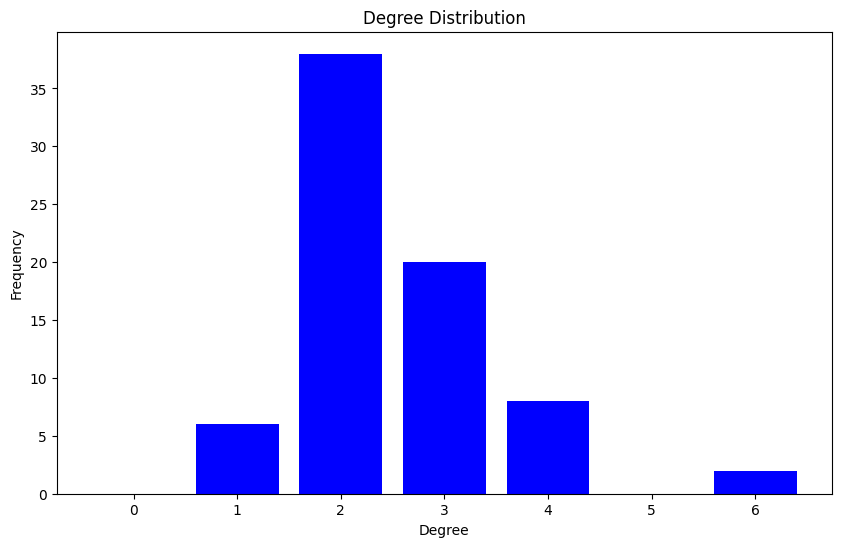

In [16]:
# compare calculated d and r values with actual values
analyze_graph(em_model)

In [17]:
nx.degree_assortativity_coefficient(em_model)

-0.03426763110307354

In [18]:
# get a degree distribution from Sioux Falls
sioux_degrees = [sioux_net.degree(n) for n in sioux_net.nodes()]
sioux_degree_counts = np.bincount(sioux_degrees)

In [19]:
# make that random model with that
sioux_graph = configuration_B(24, sioux_degree_counts)

In [20]:
sioux_graph_avg = nx.average_clustering(sioux_graph)

In [21]:
# plug that into the fitting algorithm (nodes per round as 5)
c = 0.0528
sioux_model, sioux_i, sioux_c_steps = model3(sioux_graph, sioux_graph_avg, c, c * 0.1, 5)

Total execution time: 2.06 seconds


In [22]:
sioux_model

In [23]:
sioux_i

246

In [24]:
sioux_c_steps

[0.0,
 0.22222222222222224,
 0.3819444444444444,
 0.22916666666666666,
 0.1111111111111111,
 0.34960317460317464,
 0.38055555555555554,
 0.2916666666666667,
 0.43888888888888894,
 0.18055555555555555,
 0.40277777777777773,
 0.21111111111111105,
 0.32222222222222224,
 0.40972222222222215,
 0.3211309523809523,
 0.2515873015873016,
 0.23630952380952377,
 0.31785714285714284,
 0.19166666666666668,
 0.43472222222222223,
 0.33591269841269833,
 0.22499999999999998,
 0.33749999999999997,
 0.2152777777777778,
 0.3194444444444444,
 0.49444444444444446,
 0.4851190476190476,
 0.3253968253968254,
 0.22817460317460317,
 0.2767857142857143,
 0.3725198412698412,
 0.4350198412698412,
 0.4697420634920635,
 0.26944444444444443,
 0.3152777777777778,
 0.3263888888888889,
 0.24305555555555555,
 0.2777777777777778,
 0.27777777777777773,
 0.12916666666666668,
 0.21666666666666665,
 0.2833333333333334,
 0.36250000000000004,
 0.3680555555555555,
 0.2152777777777778,
 0.2611111111111111,
 0.3194444444444445,
 0.

Diameter of the graph: 10
Average Clustering Coefficient: 0.049999999999999996


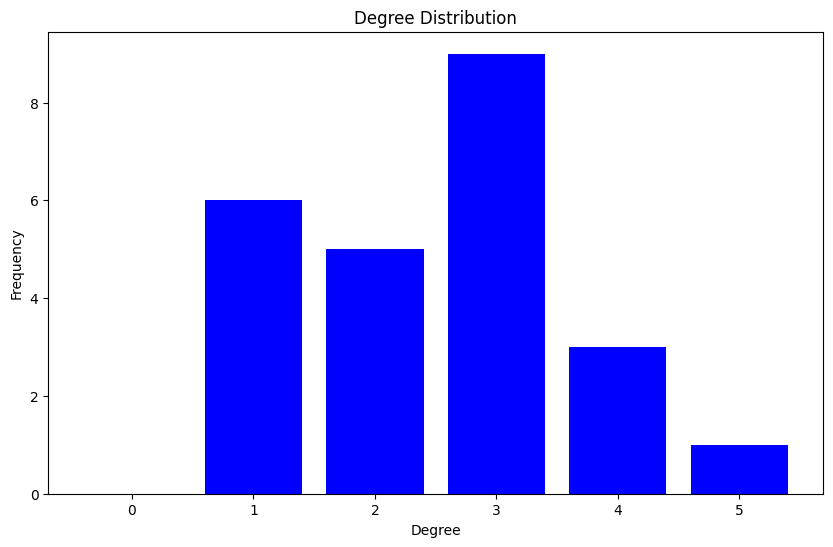

In [25]:
# compare calculated d and r values with actual values
analyze_graph(sioux_model)

In [26]:
nx.degree_assortativity_coefficient(sioux_model)

0.15151515151515266

In [27]:
# get a degree distribution from Barcelona
bar_degrees = [bar_net.degree(n) for n in bar_net.nodes()]
bar_degree_counts = np.bincount(bar_degrees)

In [28]:
# make that random model with that
bar_graph = configuration_B(1020, bar_degree_counts)

In [29]:
bar_graph_avg = nx.average_clustering(bar_graph)

In [30]:
# plug that into the fitting algorithm (nodes per round as 5)
c = 0.0902
bar_model, bar_i, bar_c_steps = model3(bar_graph, bar_graph_avg, c, c * 0.1, 5)

Function execution failed due to timeout.
Total execution time: 3600.00 seconds


In [31]:
bar_model

In [32]:
bar_i

193

In [33]:
bar_c_steps

[0.002303023773612009,
 0.0067349888673418085,
 0.009450010773540185,
 0.010735785542287091,
 0.008656257599756053,
 0.007914230019493177,
 0.0102426613920422,
 0.010496318410405098,
 0.015004123699944135,
 0.011874498337346634,
 0.006653623437679164,
 0.007649021371931587,
 0.007589448591770571,
 0.008845602568512786,
 0.009951942765410258,
 0.00962981391386964,
 0.010319002176587318,
 0.01758547309243904,
 0.0070574434738521425,
 0.009097862205447343,
 0.014754582219752498,
 0.013206808814393955,
 0.012356237816764133,
 0.007969460020543613,
 0.008905080414368337,
 0.011463221161363576,
 0.014049500980615534,
 0.019937516473894183,
 0.011132445269442173,
 0.011765562152559058,
 0.015469505268266879,
 0.008556581590637317,
 0.0051023360311286,
 0.005595033334971415,
 0.011043212606680099,
 0.010692007797270954,
 0.011345014920866316,
 0.008503158348359586,
 0.011872559271940078,
 0.00578983108394873,
 0.0070535673476849955,
 0.007488074933895366,
 0.011419029600144154,
 0.015866013071

Diameter of the graph: 23
Average Clustering Coefficient: 0.001930438842203548


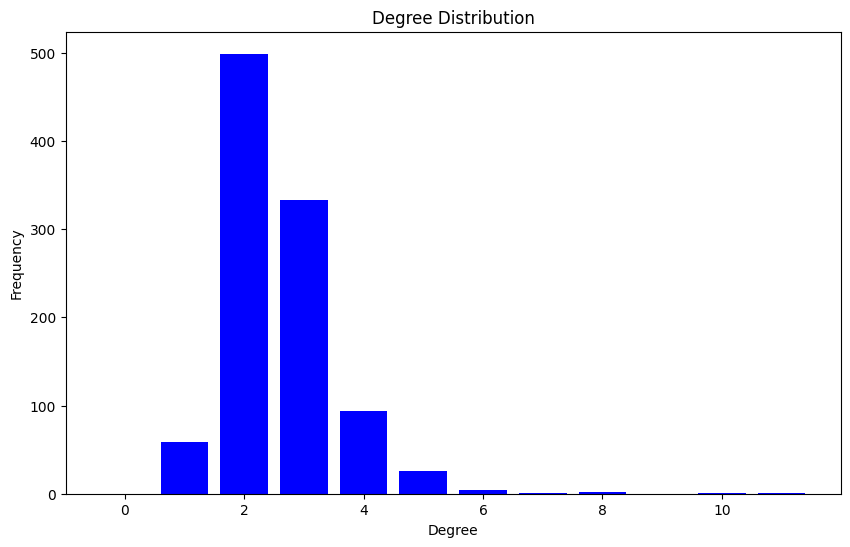

In [34]:
# compare calculated d and r values with actual values
analyze_graph(bar_model)

In [35]:
nx.degree_assortativity_coefficient(bar_model)

0.0342041758472356

In [36]:
# get a degree distribution from Sydney
syd_degrees = [syd_net.degree(n) for n in syd_net.nodes()]
syd_degree_counts = np.bincount(syd_degrees)

In [37]:
# make that random model with that
syd_graph = configuration_B(33837, syd_degree_counts)

In [38]:
syd_graph_avg = nx.average_clustering(syd_graph)

In [39]:
# plug that into the fitting algorithm (nodes per round as 5)
c = 0.0074
syd_model, syd_i, syd_c_steps = model3(syd_graph, syd_graph_avg, c, c * 0.1, 5)

KeyboardInterrupt: 

In [ ]:
syd_model

In [ ]:
syd_i

1

In [ ]:
syd_c_steps

[0.00013268754096320166]

Graph is not connected; diameter of the giant component will be calculated.
Diameter of the giant component: 29
Average Clustering Coefficient: 9.04939177783558e-05


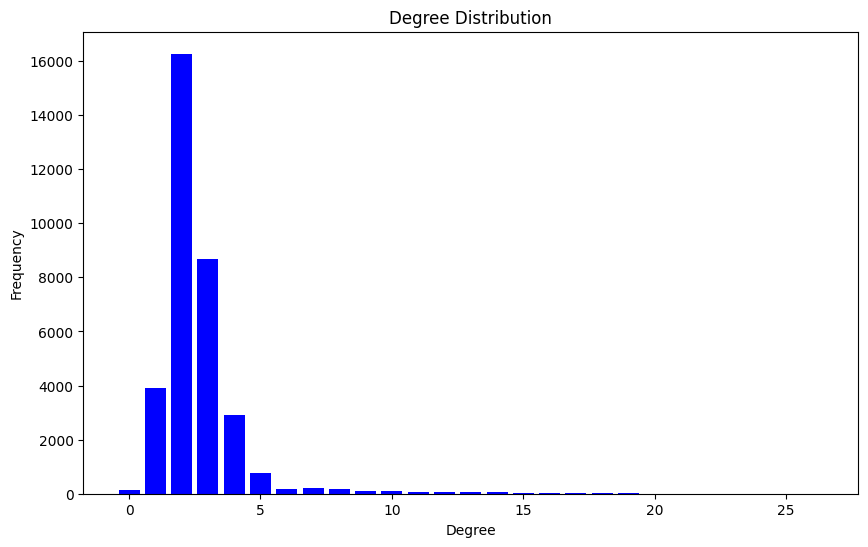

In [ ]:
# compare calculated d and r values with actual values
analyze_graph(syd_model)

In [ ]:
nx.degree_assortativity_coefficient(syd_model)

-0.012399913865099798

In [ ]:
# get a degree distribution from Winnipeg
win_degrees = [win_net.degree(n) for n in win_net.nodes()]
win_degree_counts = np.bincount(win_degrees)

In [ ]:
# make that random model with that
win_graph = configuration_B(1052, win_degree_counts)

In [ ]:
win_graph_avg = nx.average_clustering(win_graph)

In [ ]:
# plug that into the fitting algorithm (nodes per round as 5)
c = 0.1045
win_model, win_i, win_c_steps = model3(win_graph, win_graph_avg, c, c * 0.1, 5)

Function execution failed due to timeout.
Total execution time: 3600.00 seconds


In [ ]:
win_model

In [ ]:
win_i

122

In [ ]:
win_c_steps

[0.001845536781498358,
 0.016173069642651392,
 0.012032016357111413,
 0.018664030308517,
 0.011437836033843634,
 0.019986479262927487,
 0.025711110288106482,
 0.020076755649349198,
 0.027839234841303725,
 0.019839599119667164,
 0.02927586996512048,
 0.04224082040642633,
 0.0365111836913326,
 0.026809341964832326,
 0.038337404894279,
 0.03629699359549232,
 0.034645701840326185,
 0.04258775603485182,
 0.039950853746234596,
 0.03124228633325397,
 0.046381545503990915,
 0.038524143117724785,
 0.047923878034812364,
 0.040207213664906614,
 0.034134028315098375,
 0.03324010084035412,
 0.03491574653777991,
 0.037319427631260574,
 0.03692532371167625,
 0.03264142279199911,
 0.03482102346179812,
 0.03964004217946294,
 0.03666635298608728,
 0.044446487558989514,
 0.03687598584073237,
 0.039560233319330236,
 0.03738243682673581,
 0.0444697090815357,
 0.046141205812964846,
 0.04347554483338776,
 0.04022926218410376,
 0.03408918450115103,
 0.04671561048222281,
 0.044971860062928214,
 0.0392759483434

Graph is not connected; diameter of the giant component will be calculated.
Diameter of the giant component: 8
Average Clustering Coefficient: 0.04056720756992334


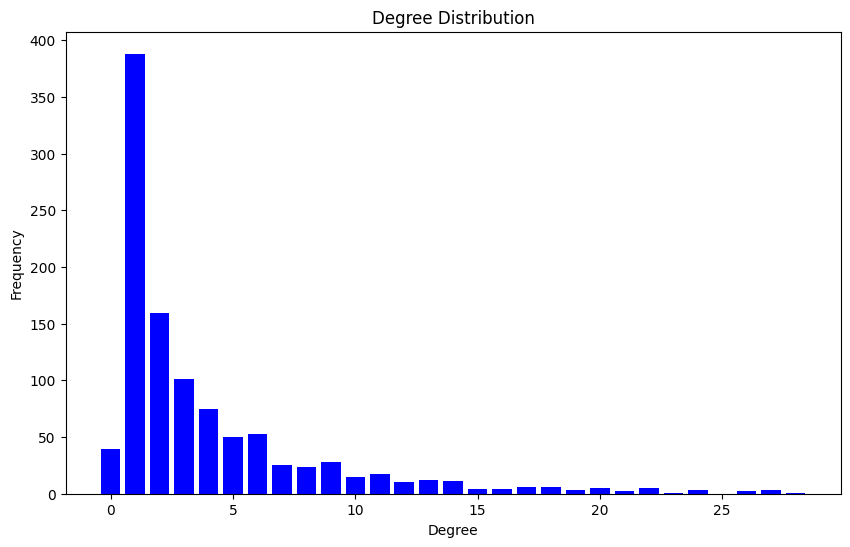

In [ ]:
# compare calculated d and r values with actual values
analyze_graph(win_model)

In [ ]:
nx.degree_assortativity_coefficient(win_model)

-0.4083234411984343

In [58]:
# get a degree distribution from Anaheim
ana_degrees = [ana_net.degree(n) for n in ana_net.nodes()]
ana_degree_counts = np.bincount(ana_degrees)

In [59]:
# make that random model with that
ana_graph = configuration_B(416, ana_degree_counts)

In [60]:
ana_graph_avg = nx.average_clustering(ana_graph)

In [61]:
# plug that into the fitting algorithm (nodes per round as 5)
c = 0.1076
ana_model, ana_i, ana_c_steps = model3(ana_graph, ana_graph_avg, c, c * 0.1, 5)

KeyboardInterrupt: 

In [ ]:
ana_model

In [ ]:
ana_i

1083

In [ ]:
ana_c_steps

[0.00921474358974359,
 0.012792589355089352,
 0.01455298174048174,
 0.04427210076248537,
 0.038632361228515065,
 0.028967386779886767,
 0.057761868755929854,
 0.06850964206733438,
 0.052371476091781506,
 0.05657911799738721,
 0.046670857187684094,
 0.04921979729672039,
 0.05598619512367575,
 0.05285920009477702,
 0.05162645230239448,
 0.05349920708376592,
 0.062214188055534206,
 0.0749512309494969,
 0.0721874813220967,
 0.06600039054083175,
 0.04591453355593627,
 0.05126582544215463,
 0.059285979778768275,
 0.0454067786788375,
 0.05669573325116314,
 0.052892838949042814,
 0.06186275783222231,
 0.05699472205987896,
 0.0488052059177625,
 0.05479498957801085,
 0.04265167925023695,
 0.04507514261343297,
 0.04712909678619519,
 0.04459382568474764,
 0.055738183174589166,
 0.048589969971548935,
 0.04626121152916966,
 0.06078245134605282,
 0.04190056659655076,
 0.05022590306530682,
 0.034475621235489654,
 0.05220257251860761,
 0.06176919838896648,
 0.05604149702074805,
 0.04781196171538368,
 0

Graph is not connected; diameter of the giant component will be calculated.
Diameter of the giant component: 8
Average Clustering Coefficient: 0.0512020651231624


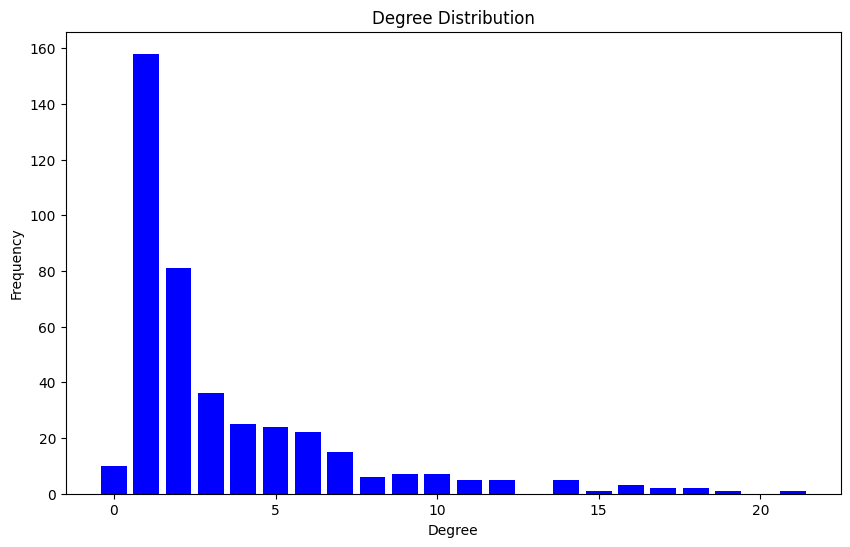

In [ ]:
# compare calculated d and r values with actual values
analyze_graph(ana_model)

In [ ]:
nx.degree_assortativity_coefficient(ana_model)

-0.3948683104036924

In [40]:
# get a degree distribution from BerlinFriedrichshain
bf_degrees = [bf_net.degree(n) for n in bf_net.nodes()]
bf_degree_counts = np.bincount(bf_degrees)

In [41]:
# make that random model with that
bf_graph = configuration_B(224, bf_degree_counts)

In [42]:
bf_graph_avg = nx.average_clustering(bf_graph)

In [43]:
# plug that into the fitting algorithm (nodes per round as 5)
c = 0.1915
bf_model, bf_i, bf_c_steps = model3(bf_graph, bf_graph_avg, c, c * 0.1, 5)

Function execution failed due to timeout.
Total execution time: 3600.04 seconds


In [44]:
bf_model

In [45]:
bf_i

4228

In [46]:
bf_c_steps

[0.005658527979956551,
 0.10323340322511042,
 0.06920255404333246,
 0.10498323378547837,
 0.10473503519307366,
 0.08926558661742211,
 0.09267702296229498,
 0.06295960968119306,
 0.08701631569693269,
 0.09922661648391415,
 0.0960552342946748,
 0.08467423851518278,
 0.057807340440163314,
 0.08953373015873016,
 0.05381944444444444,
 0.05654450227060522,
 0.09184644501740091,
 0.06076154019300028,
 0.07410847351761218,
 0.05942199796585301,
 0.04153762903762903,
 0.055289242007992005,
 0.02001574814074814,
 0.02941864682936111,
 0.05686500999000999,
 0.07496253746253746,
 0.07182400932400933,
 0.07256805694305697,
 0.06948676323676324,
 0.020900974025974024,
 0.0499045597259883,
 0.012032312925170067,
 0.03483005090147947,
 0.03816496003996004,
 0.053678266178266175,
 0.06875763125763126,
 0.03010236291486291,
 0.0403837481962482,
 0.03167162698412698,
 0.022186147186147177,
 0.037653318903318904,
 0.05776966089466091,
 0.04755817099567101,
 0.06479527417027417,
 0.06140486497629354,
 0.07

Diameter of the graph: 17
Average Clustering Coefficient: 0.03601190476190476


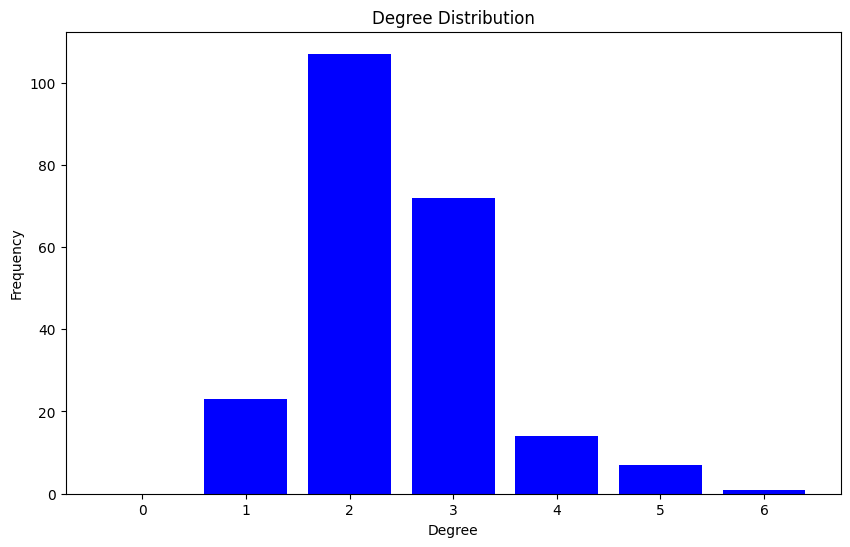

In [47]:
# compare calculated d and r values with actual values
analyze_graph(bf_model)

In [48]:
nx.degree_assortativity_coefficient(bf_model)

-0.07236680075527387

In [49]:
# get a degree distribution from Berlin-Mitte-Center
bmc_degrees = [bmc_net.degree(n) for n in bmc_net.nodes()]
bmc_degree_counts = np.bincount(bmc_degrees)

In [50]:
# make that random model with that
bmc_graph = configuration_B(398, bmc_degree_counts)

In [51]:
bmc_graph_avg = nx.average_clustering(bmc_graph)

In [52]:
# plug that into the fitting algorithm (nodes per round as 5)
c = 0.2048
bmc_model, bmc_i, bmc_c_steps = model3(bmc_graph, bmc_graph_avg, c, c * 0.1, 5)

Function execution failed due to timeout.
Total execution time: 3599.98 seconds


In [53]:
bmc_model

In [54]:
bmc_i

1318

In [55]:
bmc_c_steps

[0.003021057669298875,
 0.033289156404734295,
 0.02316770331845709,
 0.02931550582304352,
 0.028642783793537567,
 0.038383420041711504,
 0.047658148663173784,
 0.048113723239351376,
 0.018781748681246168,
 0.0296454104243049,
 0.03061822320616291,
 0.013247152066247544,
 0.024876909801532916,
 0.030669762956195126,
 0.015306329627937668,
 0.029049286838231565,
 0.02688569108167099,
 0.028031934564597887,
 0.02874980965433227,
 0.04941119740114713,
 0.029133220213622225,
 0.02011573016598142,
 0.010989289883762243,
 0.03114562712552662,
 0.03325755762941693,
 0.020050650075775698,
 0.023811336625406975,
 0.03791975751774747,
 0.024818537130094916,
 0.019570072585147962,
 0.02197694823322964,
 0.01892797319932998,
 0.02512562814070352,
 0.01699968094440456,
 0.017127303182579566,
 0.022886256680226525,
 0.01867472282045146,
 0.03312395309882748,
 0.018182180744994815,
 0.03521177315147164,
 0.012479061976549414,
 0.028148679907473877,
 0.038998564249820525,
 0.03161043311797081,
 0.01536

Graph is not connected; diameter of the giant component will be calculated.
Diameter of the giant component: 21
Average Clustering Coefficient: 0.025376884422110557


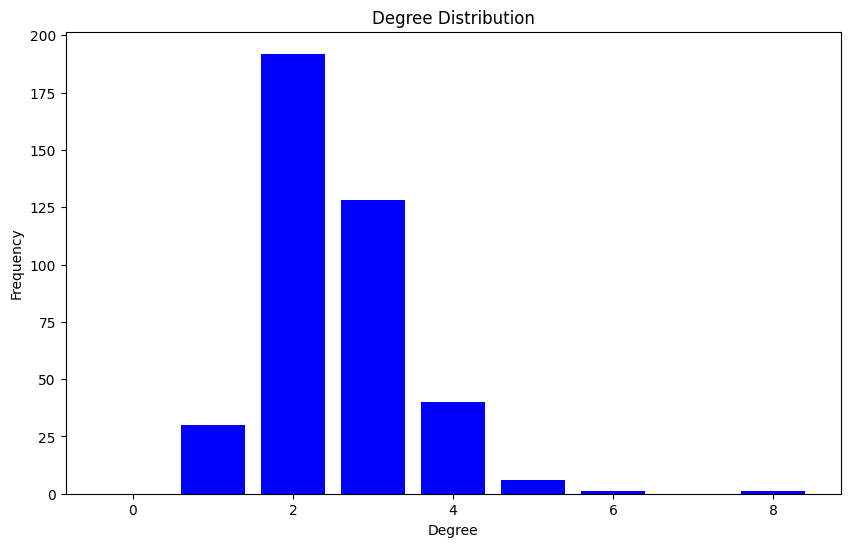

In [56]:
# compare calculated d and r values with actual values
analyze_graph(bmc_model)

In [57]:
nx.degree_assortativity_coefficient(bmc_model)

0.01632757871449337